# Learning from Examples: Line Fitting

We want to fit a straight line to data (i.e., perform linear regression). The general approach is applicable to other model classes as well.

We will compare:

* Grid search over the loss function
* The analytical solution
* Gradient descent
* Stochastic gradient descent (SGD with mini-batches)

## Simulate some data with noise

**Unknown function:** $y = f(x) = w_1x + w_0 + N(0,1)$ with $w_0 = 3$ and $w_1 = 7$

In [1]:
f <- function(x, w0, w1) w1 * x + w0 + rnorm(length(x), mean = 0, sd = 1)

Simulate 100 examples $(x, y)$. We choose for each example randomly (uniform) $x \in [0,1]$ and calculate the noisy value for $y$ using $f(x)$.

In [2]:
N <- 1000
real_w0 <- 3
real_w1 <- 7

In [3]:
x <- runif(N, 0, 1)
y <-  f(x, real_w0, real_w1)

In [4]:
xy <- data.frame(x, y)
head(xy, n = 5)

,x,y
,<dbl>,<dbl>
1,0.2217391,3.111410
2,0.9131862,8.891396
3,0.3274203,4.425074
4,0.4958543,7.398709
5,0.9935937,10.193350


Plot the noisy simulated data and add the real function $f(x)$ without the noise term as a line.

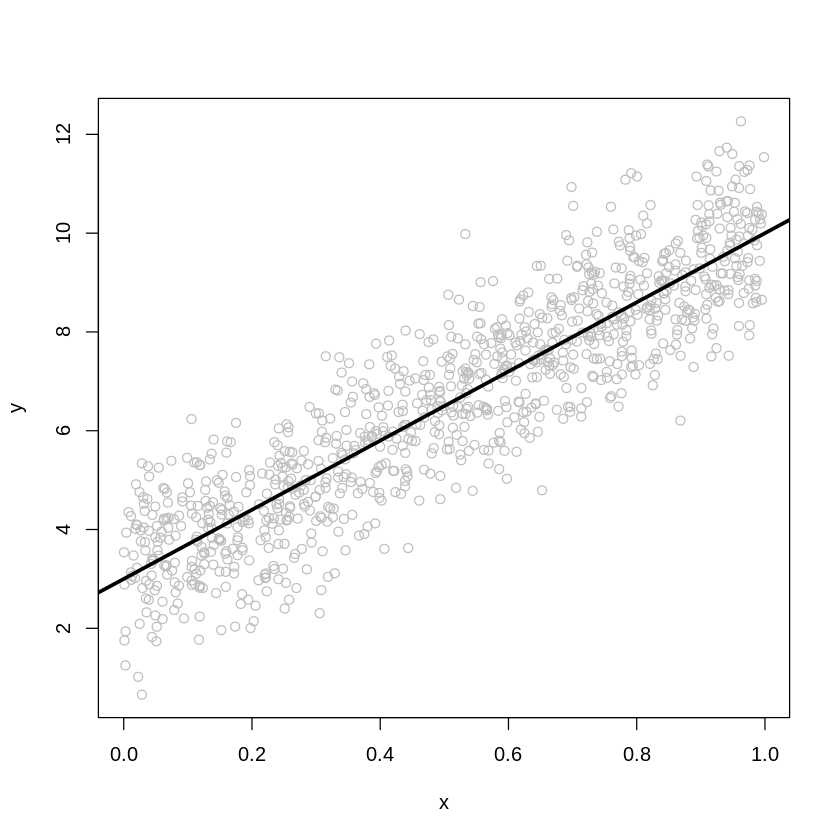

In [5]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "black", lwd = 3)

## Define the Hypothesis and the Loss Function

### Hypothesis space: Line equations 

$h_w(x) = \hat{y} = w_1 x + w_0 = \mathbf{w}^T \mathbf{x}$

In [6]:
y_hat <- function(x, w0, w1) w1 * x + w0

### Empirical Loss: Squared-error loss

$Loss(\mathbf{w}) = || \mathbf{X}\mathbf{w} - \mathbf{y} ||^2 = \sum_{j=1}^N (y_j - h_w(x_j))^2$

In [7]:
L2 <- function(y, y_hat) sum((y - y_hat)^2)

## Grid search

Create a grid of w0 and w1 values

In [8]:
resolution <- 25
grid <- data.frame(
  w0 = rep(seq(0, 10, length.out = resolution), times = resolution),
  w1 = rep(seq(0, 10, length.out = resolution), each = resolution)
)

In [9]:
grid$L2 <- with(xy, 
  apply(grid, MARGIN = 1, FUN = function(w) 
    L2(y, y_hat(x, w["w0"], w["w1"]))
  )
)

Find minimum grid cell

In [10]:
opt <- grid[which.min(grid$L2), ]
opt

,w0,w1,L2
,<dbl>,<dbl>,<dbl>
433,2.916667,7.083333,1000.114


Plot loss function surface

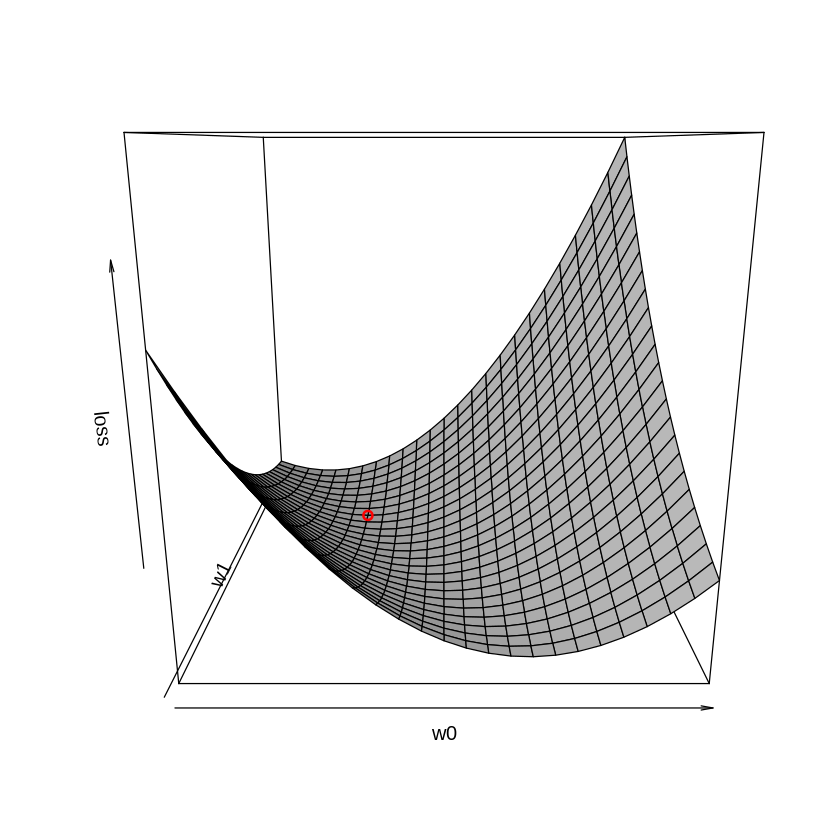

In [11]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss", shade = 0.75)
points(
  trans3d(
    x = opt[,"w0"]/max(grid[,"w0"]), 
    y = opt[,"w1"]/max(grid[,"w1"]), 
    z = opt[,"L2"], 
    pmat = pmat), 
  col = "red", lwd = 2)

plot regression line

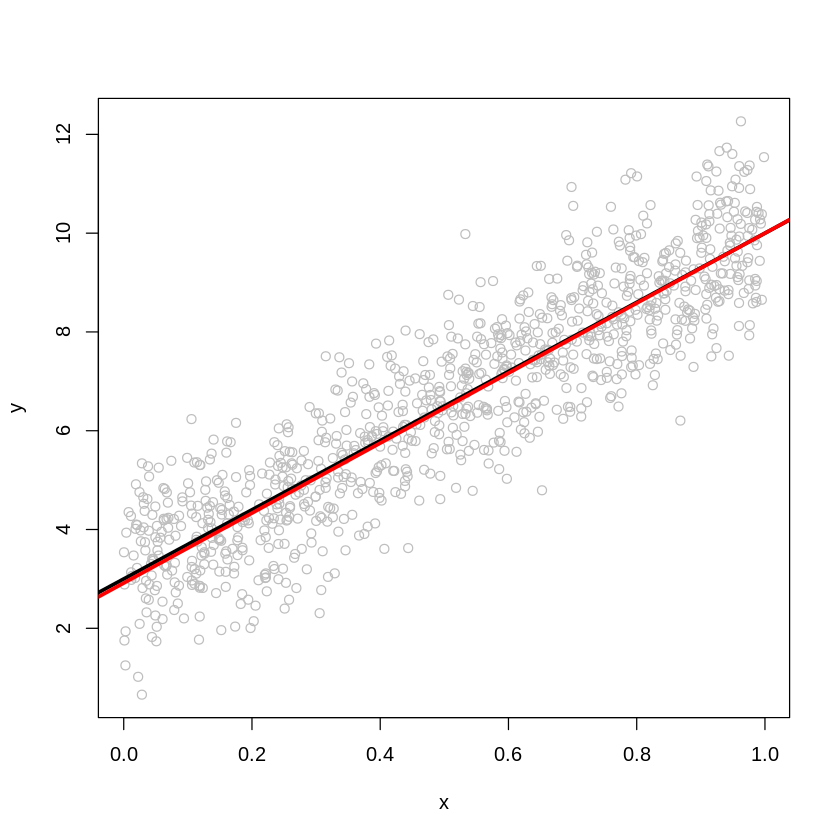

In [12]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "black", lwd = 3)
abline(a = opt$w0, b = opt$w1, col = "red", lwd = 3)

## Analytic solution

Loss is minimized by setting the gradient of the loss function to 0.

$\frac{\partial Loss}{\partial w_1}(w) = 0$ and $\frac{\partial Loss}{\partial w_0}(w) = 0$

Solution:

$w_1 = \frac{N\left(\sum x_j y_j \right) - \left(\sum x_j \right)\left(\sum y_j\right)}{N \left(\sum x_j^2 \right) - \left(\sum x_j \right)^2}$

$w_0 = \frac{\sum y_j - w_1 \left(\sum x_j \right)}{N}$

In [13]:
w1 <- with(xy, (N * sum(x*y) - sum(x)*sum(y)) / (N * sum(x^2) - sum(x)^2))
w1

[1] 7.058669

In [14]:
w0 <- with(xy, (sum(y) - w1 * sum(x)) / N)
w0

[1] 2.979637

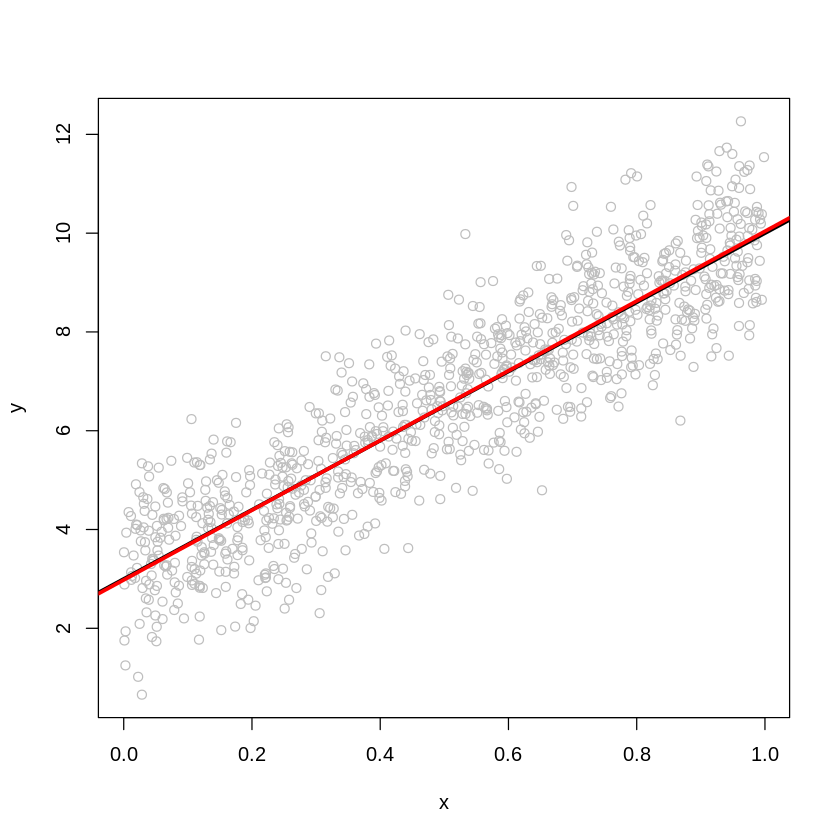

In [15]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "black", lwd = 3)
abline(a = w0, b = w1, col = "red", lwd = 3)

## Gradient descent

This is the minimization analog to hill climbing. The algorithm starts with a point in the search space. It  estimates the gradient in that point and moves a small step in the steepest downhill direction. This is repeated until it converges on a point representing a (local) minimum loss. 

The update step is

$$w_i \leftarrow w_i - \alpha \frac{\partial Loss}{\partial w_i}(\mathbf{w})$$

where $\alpha$ is called the step size. The step size can be fixed (a hyperparameter) or we can decrease it over time.

_Notes:_ 
* The loss function needs to be differentiable.
* The loss function for linear regression is convex which means that there are no local minima.

### Batch gradient descent

Update by calculating the gradient over all the training data.

In [16]:
line_BGD <- function(xy, alpha = 0.0001, epochs = 1000) {
  
  # start with some points from the parameter space
  w0 <- 0
  w1 <- 0
  
  loss <- L2(xy$y, y_hat(xy$x, w0, w1))
  
  history <- data.frame(w0, w1, loss)
  # update weights
  for (step in seq(epochs)) {
    
    # update using the gradient
    w0 <- with(xy, w0 + alpha * sum(y - y_hat(x, w0, w1)))
    w1 <- with(xy, w1 + alpha * sum((y - y_hat(x, w0, w1)) * x))
    
    loss <- L2(xy$y, y_hat(xy$x, w0, w1))
  
    history <- rbind(history, data.frame(w0, w1, loss))
  }
  list(w = c(w0 = w0, w1 = w1), history = history)
}

In [17]:
opt <- line_BGD(xy) 
opt$w

w0       w1 
2.982187 7.054016

Learning curve

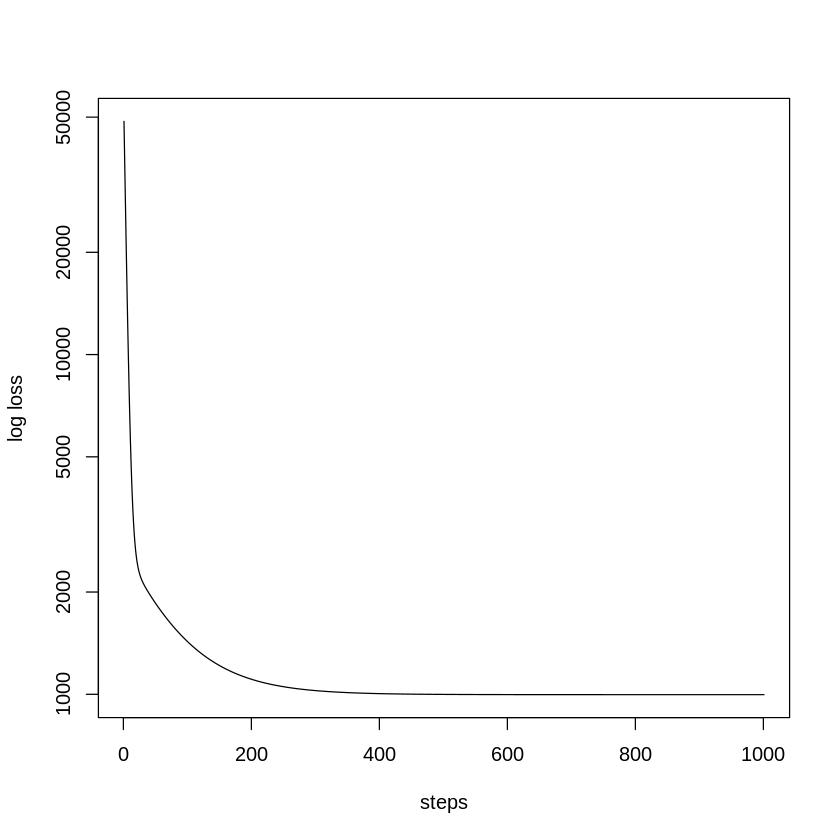

In [18]:
plot(opt$history$loss, type = "l", xlab = "steps", ylab = "log loss", log = "y")

Learning path

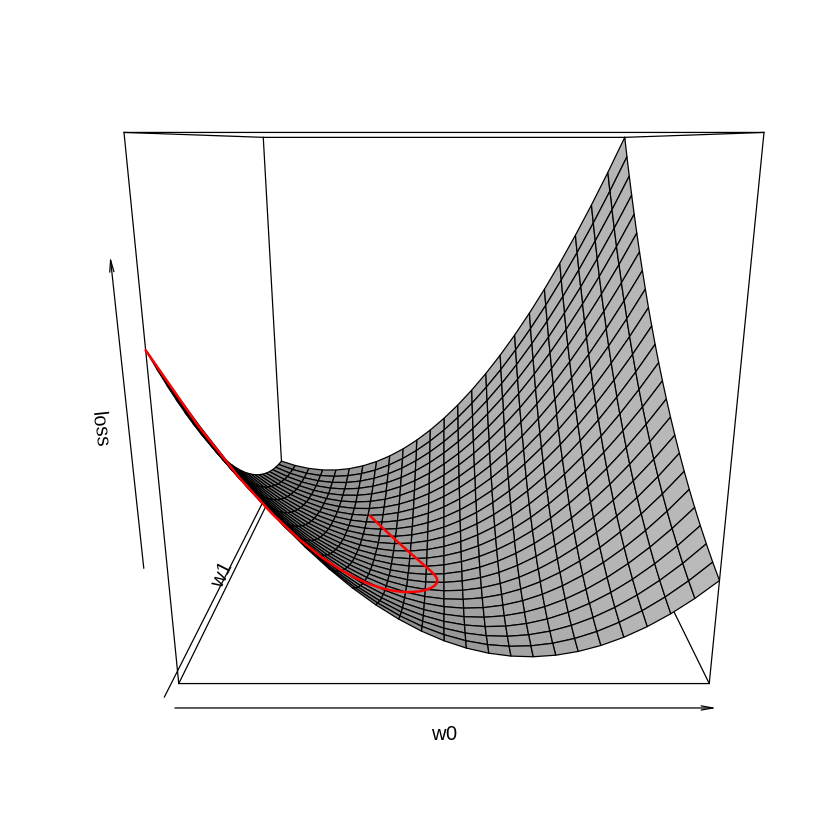

In [19]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss", shade = 0.75)
lines(
  trans3d(
    x = opt$history[,"w0"]/max(grid[,"w0"]), 
    y = opt$history[,"w1"]/max(grid[,"w1"]), 
    z = opt$history[,"loss"], 
    pmat = pmat), 
  col = "red", lwd = 2)

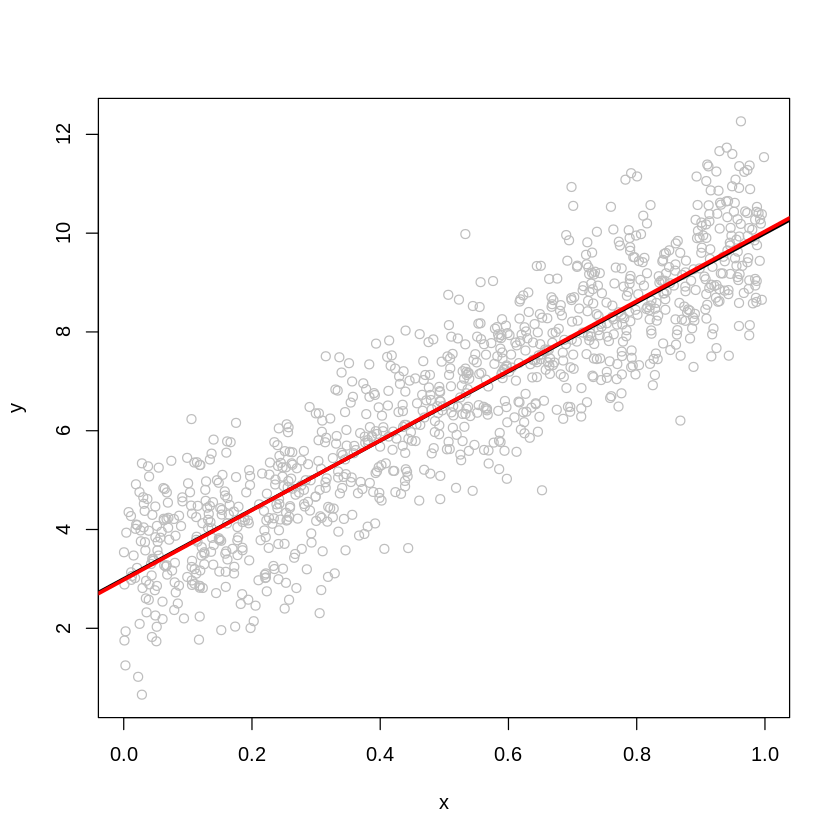

In [20]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "black", lwd = 3)
abline(a = opt$w["w0"], b = opt$w["w1"], col = "red", lwd = 3)

### Stochastic gradient descent with minibatch

Regular gradient descent is expensive since it always caclulates the gradient over all data. For non-convex problems, batch gradient descent also can land you on a saddle point.

This can be overcome with stochastic gradient descend (SGD). Pure SGD calculates the gradient every time on a single randomly choosen data point. This leads to a very 
noisy gradient which helps with escaping from saddle points or local minima. If more than one points are choosen, then the gradient estimate becomes more stable. The number of points used is a hyperparameter called the _minibatch size._

The algorithm needs more steps, since each step involves less data (only the batch).

In [21]:
line_SGD <- function(xy, batch_size = 50, alpha = 0.001, epochs = 1000, verbose = FALSE) {
  
  #' start with some points from the parameter space
  w0 <- 0
  w1 <- 0
  
  # we use loss improvement > eps to check for convergence
  loss <- L2(xy$y, y_hat(xy$x, w0, w1))
  
  history <- data.frame(w0, w1, loss)
  
  #' update weights
  for (step in seq(epochs)) {
    if(verbose) cat("Step: ", step)
    
    # choose random mini batch
    mb <- xy[sample(nrow(xy), size = batch_size),]
    
    w0 <- with(mb, w0 + alpha * sum(y - y_hat(x, w0, w1)))
    w1 <- with(mb, w1 + alpha * sum((y - y_hat(x, w0, w1)) * x))
    
    loss <- L2(xy$y, y_hat(xy$x, w0, w1))
    
    if(verbose) cat(" - loss:", loss)
      
    history <- rbind(history, data.frame(w0, w1, loss))
  }
  list(w = c(w0 = w0, w1 = w1), history = history)
}

In [22]:
opt <- line_SGD(xy, batch_size = 10, alpha = 0.001, epochs = 5000, verbose = FALSE) 
opt$w

w0       w1 
3.042489 6.925451

Learning curve

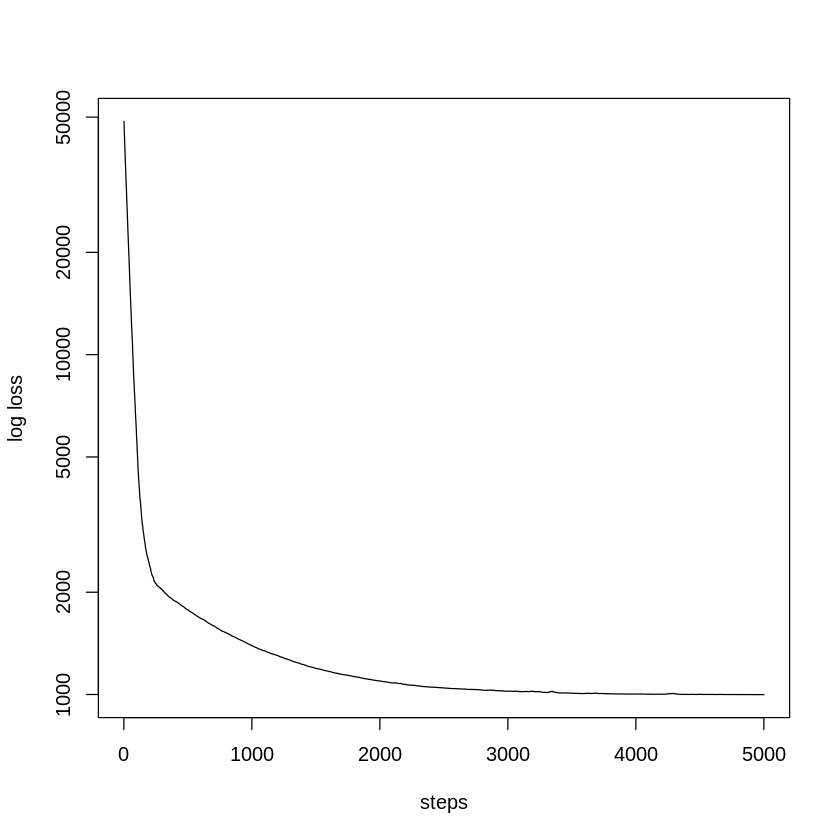

In [23]:
plot(opt$history$loss, type = "l", xlab = "steps", ylab = "log loss", log = "y")

Learning path

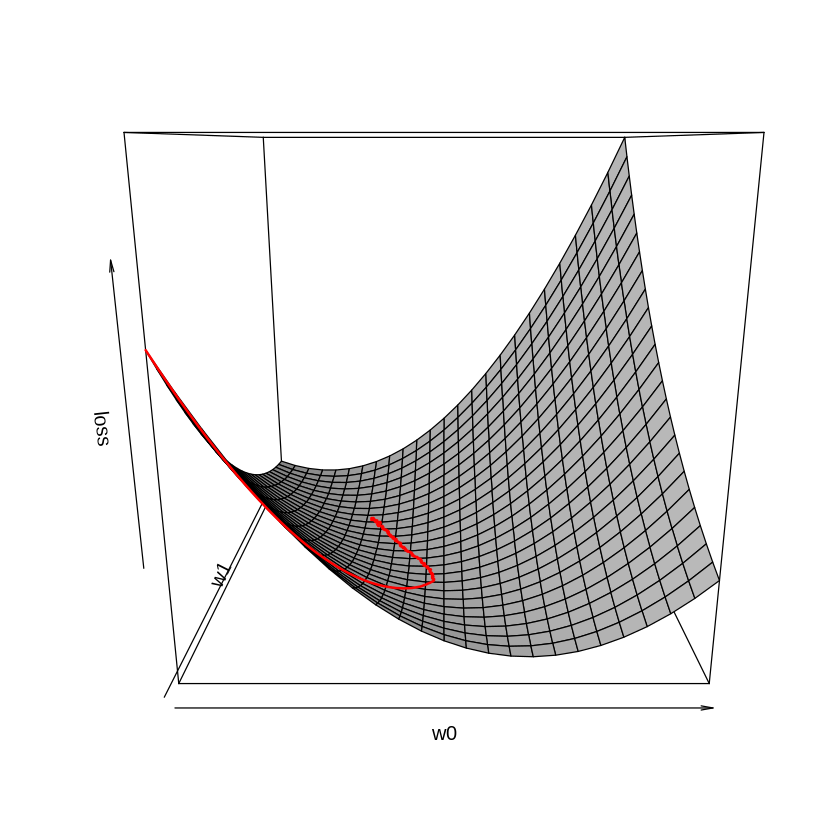

In [24]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss", shade = 0.75)
lines(
  trans3d(
    x = opt$history[,"w0"]/max(grid[,"w0"]), 
    y = opt$history[,"w1"]/max(grid[,"w1"]), 
    z = opt$history[,"loss"], 
    pmat = pmat), 
  col = "red", lwd = 2)

__Note:__ Using only a batch to estimate the gradient makes the learning path less smooth.

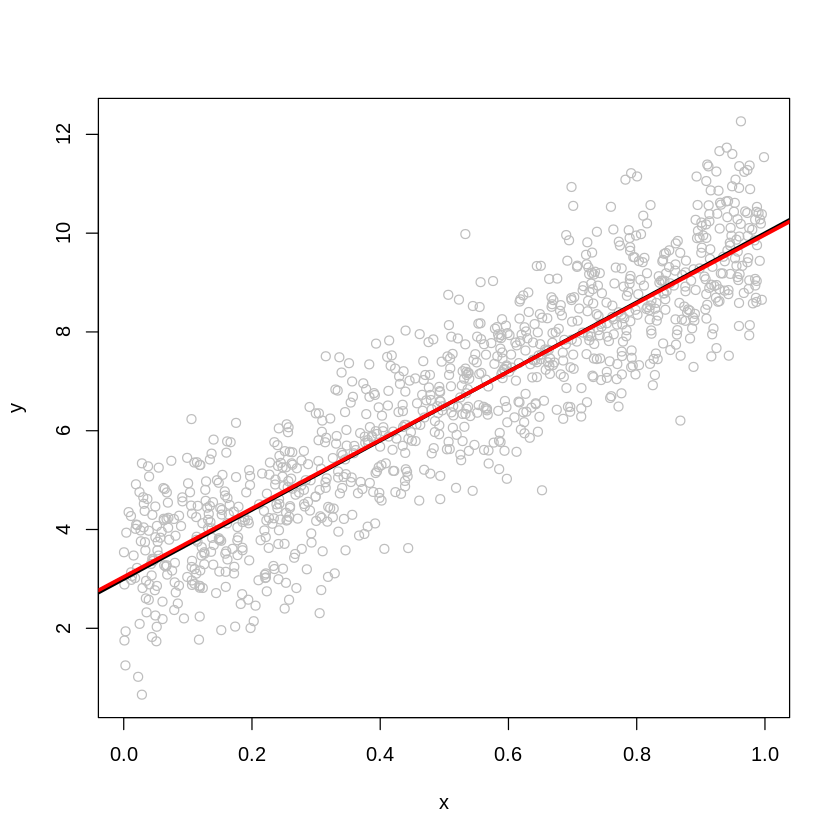

In [25]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "black", lwd = 3)
abline(a = opt$w["w0"], b = opt$w["w1"], col = "red", lwd = 3)